In [7]:
import os
import shutil

weed_classes = ['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed',
                'Fat Hen', 'Loose Silky-bent', 'Scentless Mayweed',
                'Shepherds Purse', 'Small-flowered Cranesbill']
non_weed_classes = ['Common wheat', 'Maize', 'Sugar beet']

train_dir = './train'

binary_train_dir = './binary_train'
weed_dir = os.path.join(binary_train_dir, 'weed')
non_weed_dir = os.path.join(binary_train_dir, 'non_weed')

os.makedirs(weed_dir, exist_ok=True)
os.makedirs(non_weed_dir, exist_ok=True)

for label in os.listdir(train_dir):
    label_path = os.path.join(train_dir, label)
    if os.path.isdir(label_path):
        target_class_dir = weed_dir if label in weed_classes else non_weed_dir
        for image in os.listdir(label_path):
            src_image_path = os.path.join(label_path, image)
            dst_image_path = os.path.join(target_class_dir, image)
            shutil.copy(src_image_path, dst_image_path)

print("Папка train успешно разделена на два класса: 'weed' и 'non_weed'.")

Папка train успешно разделена на два класса: 'weed' и 'non_weed'.


In [10]:
import os
import shutil
import random

def split_binary_data(source_dir, train_dir, test_dir, test_size=0.2):
    # Убедимся, что директории существуют
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(test_dir, exist_ok=True)

    for class_name in os.listdir(source_dir):
        class_path = os.path.join(source_dir, class_name)
        if os.path.isdir(class_path):
            # Создаем директории для каждого класса
            train_class_dir = os.path.join(train_dir, class_name)
            test_class_dir = os.path.join(test_dir, class_name)
            os.makedirs(train_class_dir, exist_ok=True)
            os.makedirs(test_class_dir, exist_ok=True)

            # Получаем список изображений
            images = [f for f in os.listdir(class_path) if f.endswith('.jpg') or f.endswith('.png')]
            random.shuffle(images)

            # Разделяем на тестовые и тренировочные
            split_idx = int(len(images) * (1 - test_size))
            train_images = images[:split_idx]
            test_images = images[split_idx:]

            # Копируем файлы
            for img in train_images:
                shutil.copy(os.path.join(class_path, img), os.path.join(train_class_dir, img))
            for img in test_images:
                shutil.copy(os.path.join(class_path, img), os.path.join(test_class_dir, img))

            print(f"Класс {class_name}: {len(train_images)} для тренировки, {len(test_images)} для тестирования.")

# Разделяем binary_train на тренировочные и тестовые
source_dir = 'binary_train'
train_split_dir = 'binary_train_split'
test_split_dir = 'binary_test_split'
split_binary_data(source_dir, train_split_dir, test_split_dir, test_size=0.2)

print("Данные успешно разделены!")

Класс non_weed: 661 для тренировки, 166 для тестирования.
Класс weed: 3138 для тренировки, 785 для тестирования.
Данные успешно разделены!


In [11]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm, tqdm_notebook
from PIL import Image
import glob
import pandas as pd
import matplotlib.pyplot as plt
import os

best_loss = float('inf')
best_model_path = "best_model.pth" 

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
    
testset = datasets.ImageFolder(root='binary_test_split', transform=transform)
train_ds = datasets.ImageFolder(root='binary_train_split', transform=transform)
print(len(train_ds))

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=4)
test_loader = DataLoader(testset, batch_size=32, shuffle=False, num_workers=4)

print(len(train_loader))


class SimpleCNN(nn.Module):
    def __init__(self, n_classes):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 224, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(224 * 56 * 56, 256),
            nn.ReLU(),
            nn.Linear(256, n_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
net = SimpleCNN(n_classes=2)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.0001)
num_epochs = 15

def train_net(net, optimizer, criterion, trainloader):
    net.cuda()
    total_step = len(trainloader)
    losses = []
    net.train()
    acc_list = []
    for batch, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        losses.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total = targets.size(0)
        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == targets).sum().item()
        acc_list.append(correct / total)

        if (batch + 1) % 25 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
                  .format(epoch + 1, num_epochs, batch + 1, total_step, loss.item(),
                          (correct / total) * 100))
    return losses


def valid_net(net, testloader):
    net.eval()
    net = net.to(device)
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in testloader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        print('Test Accuracy of the model: {} %'.format((correct / total) * 100))



losses = []

for epoch in range(num_epochs):
    print(f'Epoch [{epoch+1:>2d}/{num_epochs}]\n-------------------------------')
    epoch_losses = train_net(net, optimizer, criterion, train_loader)
valid_net(net, test_loader)
torch.save(net.state_dict(), 'conv_net_model.ckpt')


3799
119
cuda
Epoch [ 1/15]
-------------------------------
Epoch [1/15], Step [25/119], Loss: 0.5132, Accuracy: 84.38%
Epoch [1/15], Step [50/119], Loss: 0.3549, Accuracy: 90.62%
Epoch [1/15], Step [75/119], Loss: 0.4316, Accuracy: 87.50%
Epoch [1/15], Step [100/119], Loss: 0.6968, Accuracy: 75.00%
Epoch [ 2/15]
-------------------------------
Epoch [2/15], Step [25/119], Loss: 0.5273, Accuracy: 75.00%
Epoch [2/15], Step [50/119], Loss: 0.5460, Accuracy: 78.12%
Epoch [2/15], Step [75/119], Loss: 0.4697, Accuracy: 81.25%
Epoch [2/15], Step [100/119], Loss: 0.3907, Accuracy: 87.50%
Epoch [ 3/15]
-------------------------------
Epoch [3/15], Step [25/119], Loss: 0.4145, Accuracy: 78.12%
Epoch [3/15], Step [50/119], Loss: 0.3248, Accuracy: 90.62%
Epoch [3/15], Step [75/119], Loss: 0.2768, Accuracy: 93.75%
Epoch [3/15], Step [100/119], Loss: 0.3869, Accuracy: 78.12%
Epoch [ 4/15]
-------------------------------
Epoch [4/15], Step [25/119], Loss: 0.2976, Accuracy: 87.50%
Epoch [4/15], Step 

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from torchvision import models

# Параметры
num_epochs = 15
learning_rate = 0.0001
n_classes = 2

# Трансформации
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


# Использование ResNet
class ResNetClassifier(nn.Module):
    def __init__(self, n_classes):
        super(ResNetClassifier, self).__init__()
        # Загружаем предобученную ResNet
        self.model = models.resnet18(pretrained=True)
        # Заменяем последний слой для нашей задачи
        in_features = self.model.fc.in_features
        self.model.fc = nn.Linear(in_features, n_classes)
    
    def forward(self, x):
        return self.model(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Устройство: {device}")

# Создаем модель
resnet_model = ResNetClassifier(n_classes).to(device)

# Определяем функцию потерь и оптимизатор
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet_model.parameters(), lr=learning_rate)

# Функция обучения
def train_resnet(model, optimizer, criterion, train_loader, num_epochs):
    model.train()
    for epoch in range(num_epochs):
        print(f"\Epoch  [{epoch + 1}/{num_epochs}]")
        epoch_loss = 0
        correct = 0
        total = 0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            # Прямой проход
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            epoch_loss += loss.item()

            # Обратное распространение и обновление весов
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Подсчет точности
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()

        print(f"Avg Loss: {epoch_loss / len(train_loader):.4f}, Accuracy: {100 * correct / total:.2f}%")

# Функция валидации
def validate_resnet(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
    print(f"Test Accuracy of the model: {100 * correct / total:.2f}%")

# Обучение модели
train_resnet(resnet_model, optimizer, criterion, train_loader, num_epochs)

# Валидация
validate_resnet(resnet_model, test_loader)

# Сохранение модели
torch.save(resnet_model.state_dict(), 'resnet_model.ckpt')
print("Модель ResNet сохранена!")


Устройство: cuda


C:\Users\maxsk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\maxsk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Эпоха [1/15]
Средняя потеря: 0.1748, Точность: 92.92%

Эпоха [2/15]
Средняя потеря: 0.0598, Точность: 97.95%

Эпоха [3/15]
Средняя потеря: 0.0411, Точность: 98.68%

Эпоха [4/15]
Средняя потеря: 0.0245, Точность: 99.08%

Эпоха [5/15]
Средняя потеря: 0.0287, Точность: 99.00%

Эпоха [6/15]
Средняя потеря: 0.0222, Точность: 99.29%

Эпоха [7/15]
Средняя потеря: 0.0093, Точность: 99.74%

Эпоха [8/15]
Средняя потеря: 0.0129, Точность: 99.58%

Эпоха [9/15]
Средняя потеря: 0.0158, Точность: 99.39%

Эпоха [10/15]
Средняя потеря: 0.0059, Точность: 99.89%

Эпоха [11/15]
Средняя потеря: 0.0021, Точность: 99.97%

Эпоха [12/15]
Средняя потеря: 0.0131, Точность: 99.55%

Эпоха [13/15]
Средняя потеря: 0.0112, Точность: 99.71%

Эпоха [14/15]
Средняя потеря: 0.0050, Точность: 99.84%

Эпоха [15/15]
Средняя потеря: 0.0071, Точность: 99.74%
Точность на тестовых данных: 98.63%
Модель ResNet сохранена!


In [ ]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, f1_score
import numpy as np

# Генерация мета-признаков
def generate_meta_features(base_models, dataloader, device):
    meta_features = []
    true_labels = []

    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        batch_features = []
        for model in base_models:
            model.eval()
            outputs = model(inputs)
            probabilities = F.softmax(outputs, dim=1).cpu().detach().numpy()
            batch_features.append(probabilities)
        meta_features.append(np.hstack(batch_features))
        true_labels.append(labels.numpy())
    
    return np.vstack(meta_features), np.concatenate(true_labels)

# Базовые модели
base_models = [net, resnet_model]

# Генерация мета-признаков для обучающего и тестового набора
train_meta_features, train_labels = generate_meta_features(base_models, train_loader, device)
test_meta_features, test_labels = generate_meta_features(base_models, test_loader, device)

# Обучение XGBoost как метамодели
xgb_model = xgb.XGBClassifier(n_estimators=100, max_depth=5, learning_rate=0.1)
xgb_model.fit(train_meta_features, train_labels)

# Предсказания и оценка
preds = xgb_model.predict(test_meta_features)
xgb_accuracy = accuracy_score(test_labels, preds)
xgb_f1 = f1_score(test_labels, preds, average='weighted')

print(f"Метрика Accuracy для улучшенного ансамбля: {xgb_accuracy:.4f}")
print(f"Метрика F1 для улучшенного ансамбля: {xgb_f1:.4f}")


Метрика Accuracy для улучшенного ансамбля: 0.9853
Метрика F1 для улучшенного ансамбля: 0.9852


SimpleCNN Classification Report:
               precision    recall  f1-score   support

    non_weed       0.70      0.75      0.72       166
        weed       0.95      0.93      0.94       785

    accuracy                           0.90       951
   macro avg       0.82      0.84      0.83       951
weighted avg       0.90      0.90      0.90       951

ResNet Classification Report:
               precision    recall  f1-score   support

    non_weed       0.99      0.93      0.96       166
        weed       0.98      1.00      0.99       785

    accuracy                           0.99       951
   macro avg       0.99      0.96      0.98       951
weighted avg       0.99      0.99      0.99       951



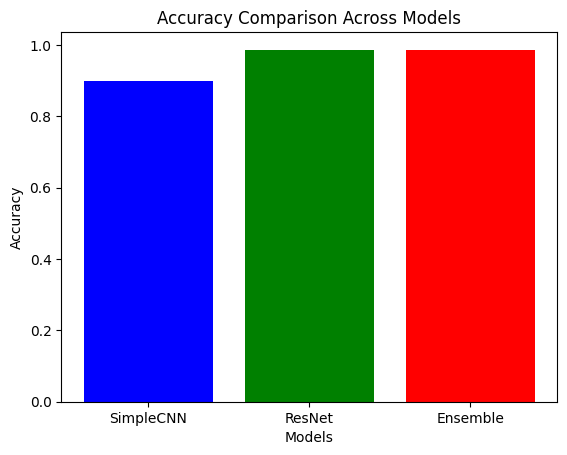

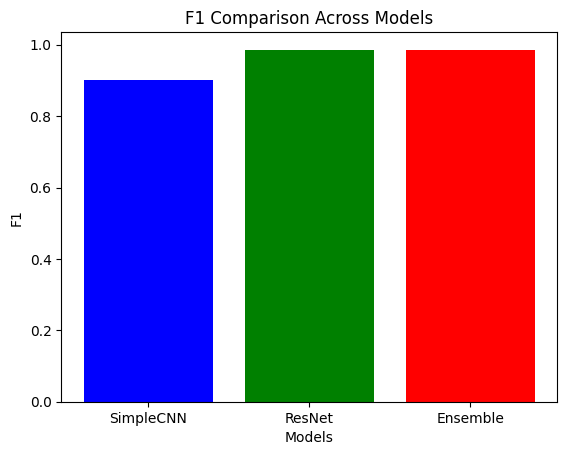

In [ ]:
import numpy as np
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, accuracy_score, f1_score
import matplotlib.pyplot as plt
import torch

def compute_f1_for_model(model, loader, device):
    model.eval()
    model = model.to(device)
    y_true = []
    y_pred = []
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average="weighted")
    report = classification_report(y_true, y_pred, target_names=testset.classes)

    return accuracy, f1, report

def plot_metrics(metrics, labels, metric_name):
    x = np.arange(len(labels))
    values = [metrics[label] for label in labels]

    plt.bar(x, values, color=['blue', 'green', 'red'])
    plt.xticks(x, labels)
    plt.xlabel("Models")
    plt.ylabel(metric_name)
    plt.title(f"{metric_name} Comparison Across Models")
    plt.show()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

simple_cnn_accuracy, simple_cnn_f1, simple_cnn_report = compute_f1_for_model(net, test_loader, device)

resnet_accuracy, resnet_f1, resnet_report = compute_f1_for_model(resnet_model, test_loader, device)

metrics = {
    "SimpleCNN": {
        "Accuracy": simple_cnn_accuracy,
        "F1": simple_cnn_f1
    },
    "ResNet": {
        "Accuracy": resnet_accuracy,
        "F1": resnet_f1
    },
    "Ensemble": {
        "Accuracy": xgb_accuracy,
        "F1": xgb_f1
    }
}

print("SimpleCNN Classification Report:\n", simple_cnn_report)
print("ResNet Classification Report:\n", resnet_report)

labels = ["SimpleCNN", "ResNet", "Ensemble"]
plot_metrics({k: v['Accuracy'] for k, v in metrics.items()}, labels, "Accuracy")
plot_metrics({k: v['F1'] for k, v in metrics.items()}, labels, "F1")

In [ ]:
# В результате работы было создано две базовые модели SimpleCNN и Resnet
# Так же была создана стакинг метамодель ансамбля при помощи xgb.XGBClassifier
# сравнив три модели видно что модель resnet значительнео превосходит модель simpleCNN а так же незначительно превоходит метамодель ансамбля
# в сервисе бует использована лучшая модель - resnet